In [2]:
import numpy as np
import matplotlib.pyplot as plt

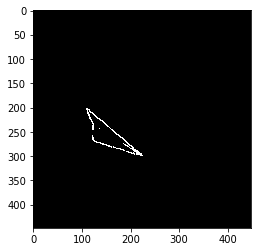

In [3]:

# 路径图像（坐标放到图片里看需要放大2倍）
path_image=np.load("TSP_Unet_out/out/0.npy")
plt.imshow(path_image,cmap=plt.cm.gray)
plt.show()

In [6]:
# coor = np.load("out/KMeans_1.npy")
coor = np.load("partial_npy/0.npy")
print(coor)

[[110 160]
 [ 96 103]
 [ 44 118]
 [ 34  95]]
